```{contents}
```

## GRU

**GRU (Gated Recurrent Unit)** is a simplified version of the **LSTM**, designed to achieve similar long-term memory performance with fewer parameters and faster computation.

---

### Intuition

Standard RNNs forget long-term dependencies because gradients vanish over time.
LSTMs solved this using three gates and a cell state.
GRUs simplify that design to **two gates** and **one hidden state**, making training faster while retaining memory efficiency.

Think of GRU as a **“compressed LSTM”** — it merges the forget and input gates into one **update gate**, reducing computation without sacrificing much accuracy.

---

#### 2. **Architecture Overview**

| Gate                      | Function                                                           | Analogy                  |
| ------------------------- | ------------------------------------------------------------------ | ------------------------ |
| **Update Gate ($z_t$)** | Controls how much of the past information to keep                  | Memory retention knob    |
| **Reset Gate ($r_t$)**  | Controls how much past info to forget when computing the new state | Short-term forget switch |

Unlike LSTM, GRU **does not use a separate cell state**.
Its hidden state $h_t$ carries both short-term and long-term information directly.

---

#### 3. **Mathematical Workflow**

Let:

* $x_t$: input at time *t*
* $h_{t-1}$: previous hidden state
* $W, U, b$: learnable weights and biases
* $\sigma$: sigmoid function
* $\tanh$: hyperbolic tangent

---

**Step 1: Update Gate**

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$

Determines how much of the old state to retain.

---

**Step 2: Reset Gate**

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$

Controls how much of the previous hidden state to forget.

---

**Step 3: Candidate Hidden State**

$$
\tilde{h}*t = \tanh(W_h x_t + U_h (r_t * h*{t-1}) + b_h)
$$

Applies reset gate to decide how much old info influences the new state.

---

**Step 4: New Hidden State**

$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

Blends the old hidden state and the candidate new one, weighted by the update gate.

---

#### 4. **Workflow Summary**

| Step | Gate                      | Operation                         | Output              |
| ---- | ------------------------- | --------------------------------- | ------------------- |
| 1    | Update $z_t$            | Controls how much past to keep    | Memory retention    |
| 2    | Reset $r_t$             | Controls how much past to discard | Forget mechanism    |
| 3    | Candidate $\tilde{h}_t$ | Generates new content             | Proposed new memory |
| 4    | Final Update $h_t$      | Combines old + new info           | Updated memory      |

---

#### 5. **Key Differences from LSTM**

| Aspect              | LSTM                              | GRU                              |
| ------------------- | --------------------------------- | -------------------------------- |
| Gates               | 3 (input, forget, output)         | 2 (update, reset)                |
| Cell state          | Separate $C_t$                  | Merged with hidden state $h_t$ |
| Parameters          | More (slower)                     | Fewer (faster)                   |
| Control granularity | More fine-tuned                   | More compact                     |
| Performance         | Slightly better on long sequences | Comparable, often faster         |

![alt text](../../images/gru.png)
---

#### 6. **Advantages**

* Faster training and inference
* Fewer parameters → less memory use
* Handles vanishing gradients well
* Performs competitively with LSTM on many tasks

---

#### 7. **Disadvantages**

* May underperform LSTM on very long or highly complex sequences
* Slightly less flexible (since it merges cell and hidden states)

---

#### 8. **Applications**

* Speech recognition
* Sentiment analysis
* Time-series prediction
* Text generation

---

**Intuitive Summary:**
GRU = *LSTM with two knobs instead of three.*
It forgets and remembers efficiently, but with fewer moving parts.

### Demonstration


#### 🧩 **Cell 1 — Install and Import Libraries**

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt


---

#### 🧩 **Cell 2 — Generate Synthetic Time Series Data**

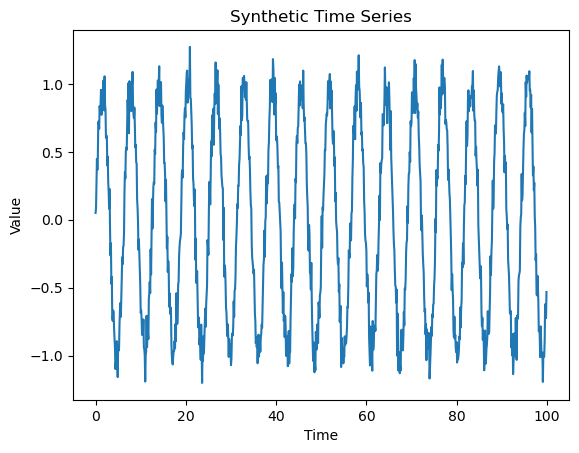

In [2]:

np.random.seed(42)
time = np.arange(0, 100, 0.1)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))

plt.plot(time, data)
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


---

### 🧩 **Cell 3 — Prepare Data for GRU**

In [3]:

window_size = 20
X, y = [], []

for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    y.append(data[i + window_size])

X = np.array(X).reshape(-1, window_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 784, Test samples: 196


#### **Cell 4 — Define Hyperparameter Grid and Callbacks**

In [4]:

# Hyperparameter combinations
batch_sizes = [16, 32]
learning_rates = [0.001, 0.005]
dropouts = [0.1, 0.3]

# Learning rate scheduler: decay after 10 epochs
def lr_scheduler(epoch, lr):
    return lr * 0.9 if epoch > 10 else lr

# Early stopping: stop if val_loss doesn't improve for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)


#### 🧩 **Cell 5 — Train and Evaluate GRU Models**

In [5]:

results = []

for batch_size, lr, dropout_rate in itertools.product(batch_sizes, learning_rates, dropouts):
    model = Sequential([
        GRU(50, input_shape=(window_size, 1)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
    )

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results.append((batch_size, lr, dropout_rate, test_loss))

results_df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Dropout", "Test Loss"])
results_df


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,Batch Size,Learning Rate,Dropout,Test Loss
0,16,0.001,0.1,0.012208
1,16,0.001,0.3,0.012001
2,16,0.005,0.1,0.011746
3,16,0.005,0.3,0.012224
4,32,0.001,0.1,0.012121
5,32,0.001,0.3,0.012064
6,32,0.005,0.1,0.011695
7,32,0.005,0.3,0.011585


#### 🧩 **Cell 6 — Select Best Configuration**

In [6]:


best_config = results_df.loc[results_df["Test Loss"].idxmin()]
print("Best Configuration:")
print(best_config)


Best Configuration:
Batch Size       32.000000
Learning Rate     0.005000
Dropout           0.300000
Test Loss         0.011585
Name: 7, dtype: float64


#### 🧩 **Cell 7 — Retrain Best GRU and Visualize Predictions**

Epoch 1/50


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2547 - val_loss: 0.0398 - learning_rate: 0.0050
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0375 - val_loss: 0.0237 - learning_rate: 0.0050
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0279 - val_loss: 0.0154 - learning_rate: 0.0050
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0259 - val_loss: 0.0137 - learning_rate: 0.0050
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - val_loss: 0.0143 - learning_rate: 0.0050
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0230 - val_loss: 0.0133 - learning_rate: 0.0050
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - val_loss: 0.0145 - learning_rate: 0.0050
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245 - val_loss: 0.0151 - learning_rate: 0.0050
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222 - val_loss: 0.0135 - learning_rate: 0.0050
Epoch 10/50
23/23 ━━━━━━━━━━━━

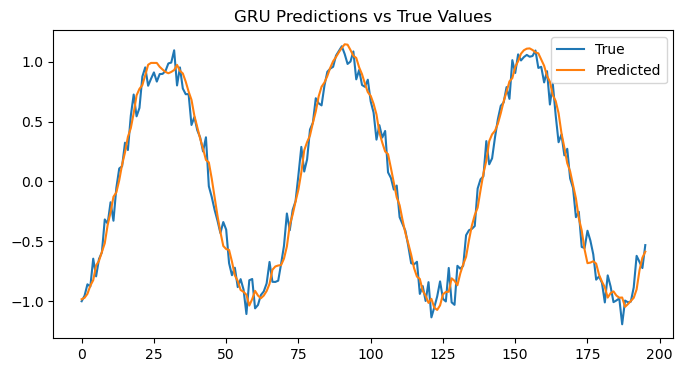

In [7]:
best_batch = int(best_config["Batch Size"])
best_lr = float(best_config["Learning Rate"])
best_dropout = float(best_config["Dropout"])

best_model = Sequential([
    GRU(50, input_shape=(window_size, 1)),
    Dropout(best_dropout),
    Dense(1)
])
best_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))

history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
)

preds = best_model.predict(X_test)

plt.figure(figsize=(8,4))
plt.plot(y_test, label="True")
plt.plot(preds, label="Predicted")
plt.title("GRU Predictions vs True Values")
plt.legend()
plt.show()




---

**Summary**

| Step | Operation                          | Purpose                                   |
| ---- | ---------------------------------- | ----------------------------------------- |
| 1    | Generate time-series data          | Create training data                      |
| 2    | Prepare windowed dataset           | Feed GRU sequences                        |
| 3    | Train GRU with hyperparameter grid | Optimize performance                      |
| 4    | Apply EarlyStopping + LR Scheduler | Avoid overfitting and improve convergence |
| 5    | Select best configuration          | Choose optimal setup                      |
| 6    | Retrain + visualize predictions    | Validate generalization                   |

---

**Tunable Parameters**

| Hyperparameter | Typical Range | Effect                  |
| -------------- | ------------- | ----------------------- |
| Units          | 32–128        | Memory capacity         |
| Learning Rate  | 0.001–0.01    | Training speed          |
| Dropout        | 0.1–0.5       | Regularization          |
| Batch Size     | 16–64         | Gradient stability      |
| Window Size    | 10–50         | Sequence context length |
